# 국민청원 데이터로 이진 분류하기

* 예제로 응답여부를 0과 1로 예측합니다.
* 응답여부 외에도 청원의 카테고리를 예측하는 분류를 해볼 수도 있을것 같아요. 
* 이 예제를 참고하여 응답여부외에 청원내용으로 평균 이상의 투표를 받을 것인지 여부를 예측해 보면 좋겠습니다.

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [2]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어온다.
petitions = pd.read_csv('data/petition.csv', index_col=0, \
                        parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 본다.
petitions.shape

(192387, 7)

In [3]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져온다.
df = petitions.loc[petitions['votes'] > 1000]
df.shape

(1687, 7)

In [4]:
# 답변 대상 건이 몇 건인지 본다.
df.loc[df['answered'] == 1].shape

(26, 7)

In [5]:
df.head()

,start,end,answered,votes,category,title,content
article_id,,,,,,,
28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...
43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된..."
46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된..."
50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...
61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...


In [6]:
# 샘플로 보고 싶은 인덱스의 번호를 넣어주세요.
sample_index = 28

In [7]:
sample_title = df['title'][sample_index]
sample_title

'소액주주를 보호해주십시오'

In [8]:
sample_content = petitions['content'][sample_index]
sample_content

'**  존경하옵는 문재인대통령님께\\n저는 중국원양자원이라는 KOSPI상장사의 소액 주주입니다. 중국원양자원(이하 중원)은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고 있습니다.\\n상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수 있습니다.\\n결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 및 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다.\\n이로인해 약 2만 5천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다.\\n주식투자는 개인의 판단하에 이루어지는 것이나 투자에 대한 개인의 책임을 묻기전에 그 과정은 규정과 상식에 맞게 공정하고 정의로워야 할 것입니다. 이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템, 특히 거래소와 회계감사는 그렇지 못한 것 같습니다.\\n이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다\\n이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 많은 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고 있습니다. .\\n기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 대한 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야 합니다.\\n그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의\'결정적 이유\'로 명시하였는바 이는 감사자의 \'의견거절\'에 따른 참혹한 결과로 볼때 

# 전처리 하기 

In [9]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [10]:
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    # stops_right = ['있습니다', '합니다', '하는', '없는', '입니다','같습니다', '없습니다', '한다']
    # 불용어 제거
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [11]:
pre_sample_content = preprocessing(sample_content)

In [12]:
remove_stopwords(pre_sample_content)

'    존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니다  중국원양자원 이하 중원 은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고  상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수  결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다  이로인해 약  만  천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다  주식투자는 개인의 판단하에 이루어지는 것이나 투자에 개인의 책임을 묻기전에 과정은 규정과 상식에 맞게 공정하고 정의로워야 것입니다  이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템  특히 거래소와 회계감사는 그렇지 못한 것  이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다 이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고    기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야  그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의 결정적 이유 로 명시하였는바 이는 감사자의  의견거절 에 따른 참혹한 결과로 볼때      명의 국민들과 가족들은 공정한 감사결과라 절대로 인정할수  고통의 원인은 법 제도나 규정에 근거를 두지 않

In [13]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 241 ms, sys: 70.6 ms, total: 311 ms
Wall time: 321 ms


/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 356 ms, sys: 36 ms, total: 392 ms
Wall time: 397 ms


/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


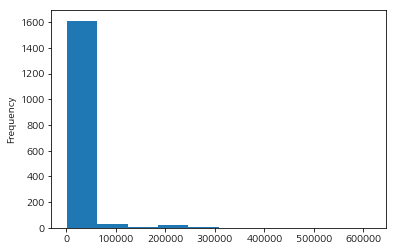

In [15]:
%matplotlib inline
df['votes'].plot.hist()

In [16]:
df_4 = df.loc[df['votes'] < 200000]
df_4.shape

(1649, 9)

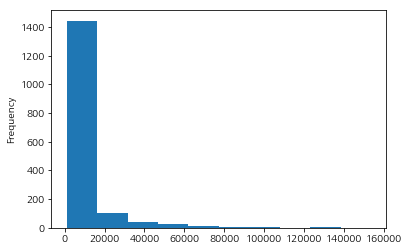

In [17]:
df_4['votes'].plot.hist()

In [18]:
# 아웃라이어 데이터를 제거하고 다시 df를 만들어 줍니다.
df = df_4

# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [19]:
df = df.reindex()

In [20]:
df.shape

(1649, 9)

In [21]:
split_count = int(df.shape[0] * 0.7)
split_count

1154

In [22]:
df_train = df[:split_count]
df_train.shape

(1154, 9)

In [23]:
df_train.head()

,start,end,answered,votes,category,title,content,content_preprocessing,content_preprocessing2
article_id,,,,,,,,,
28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...
61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...


In [24]:
# 학습 세트의 답변 대상 건이 몇 건인지 본다.
df_train.loc[df_train['answered'] == 1].shape

(0, 9)

In [25]:
df_test = df[split_count:]
df_test.shape

(495, 9)

In [26]:
df_test.head()

,start,end,answered,votes,category,title,content,content_preprocessing,content_preprocessing2
article_id,,,,,,,,,
178954,2018-03-28,2018-04-27,0,2030,안전/환경,김부겸 행정안전부 장관님께 정확한 사실관계 확인 부탁드립니다.,"道 기획조정실, 일방적 사업 축소 반발 일자 신규채용 관련 감사도\n소방관들 “업무...",기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...,기획조정실 일방적 사업 축소 반발 일자 신규채용 관련 감사도 소방관들 업무영...
179146,2018-03-29,2018-04-28,0,16216,보건복지,저희 엄마 사망의 진실을 알려주십시오,저는 며칠 전 병원에서 엄마를 잃었습니다.\n그런데 병원측의 너무나 어처구니 없는 ...,저는 며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 없는 대...,며칠 전 병원에서 엄마를 잃었습니다 그런데 병원측의 너무나 어처구니 대처로 억울하...
179162,2018-03-29,2018-04-28,0,6698,육아/교육,총신대 사태의 희생양이된 학생들을 전과자로 만들어서는 결코 안됩니다.,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 수 ...,간섭하려는 총회와 간섭 받지 않으려는 재단 사이의 갈등을 책임자들이 대화로 풀 없어...
179317,2018-03-29,2018-04-28,0,1018,교통/건축/국토,무책임한 집주인 및 임대사업자에 대한 대책을 마련해주세요,요즘 깡통전세 등 전세 세입자의 전재산으로 볼 수 있는 전세 보증금을 보장 받지 못...,요즘 깡통전세 등 전세 세입자의 전재산으로 볼 수 있는 전세 보증금을 보장 받지 못...,요즘 깡통전세 전세 세입자의 전재산으로 볼 전세 보증금을 보장 받지 못하는 사례가 ...
179421,2018-03-29,2018-04-28,0,2052,반려동물,동물보호법 강화 부탁드립니다,"""한 나라의 위대성과 그 도덕성은 동물들을 다루는 태도로 판단할 수 있다. 나는 나...",한 나라의 위대성과 그 도덕성은 동물들을 다루는 태도로 판단할 수 있다 나는 나...,나라의 위대성과 도덕성은 동물들을 다루는 태도로 판단할 있다 나는 나약한 동물일...


In [27]:
# 테스트 세트의 답변 대상 건이 몇 건인지 본다.
df_test.loc[df_test['answered'] == 1].shape

(0, 9)

# 단어 벡터화 하기

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [29]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 3.73 s, sys: 207 ms, total: 3.94 s
Wall time: 4.58 s


In [30]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 1.58 s, sys: 78.2 ms, total: 1.66 s
Wall time: 1.95 s


In [31]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'and',
 'article',
 'articleview',
 'as',
 'co',
 'co kr',
 'co kr news',
 'com',
 'com main']

In [32]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,and,article,articleview,as,co,co kr,co kr news,com,com main,...,후에,훨씬,휴게시간,휴게시간을,힘든,힘들게,힘들어,힘없는,힘을,힘이
0,39,32,61,48,48,19,109,103,47,199,...,42,33,68,31,20,18,21,18,42,25


In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [34]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 4.42 ms, sys: 2.71 ms, total: 7.13 ms
Wall time: 5.99 ms


In [35]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 3.46 ms, sys: 1.73 ms, total: 5.19 ms
Wall time: 4.63 ms


In [36]:
test_feature_tfidf.shape

(495, 2000)

# 학습시키기

In [37]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [38]:
# 학습에 사용할 y_label 을 넣어준다.
y_label = df_train['answered']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 160 ms, sys: 31.6 ms, total: 191 ms
Wall time: 196 ms


# 정확도 측정

In [39]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

scoring = 'accuracy'
score = cross_val_score(forest, train_feature_tfidf, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
round(np.mean(score)*100,2)

100.0

# 예측

In [41]:
# 테스트 데이터를 넣고 예측한다.
y_pred = forest.predict(test_feature_tfidf)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'answered':y_pred})
output.head()

,answered
0,0
1,0
2,0
3,0
4,0


In [43]:
# 0과 1이 어떻게 집계 되었는지 확인한다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었다.
output['answered'].value_counts()

0    495
Name: answered, dtype: int64

In [44]:
y_test = df_test['answered']
y_test.shape

(495,)

In [45]:
y_pred.shape

(495,)